# Tutorial Part 3: Introduction to Graph Convolutions

In the previous sections of the tutorial, we learned about `Dataset` and `Model` objects. We learned how to load some data into DeepChem from files on disk and also learned some basic facts about molecular data handling. We then dove into some basic deep learning architectures and explored DeepChem's `TensorGraph` framework for deep learning. However, until now, we stuck with vanilla deep learning architectures and didn't really consider how to handle deep architectures specifically engineered to work with life science data.

In this tutorial, we'll change that by going a little deeper and learn about "graph convolutions." These are one of the most powerful deep learning tools for working with molecular data. The reason for this is that molecules can be naturally viewed as graphs.

![Molecular Graph](basic_graphs.gif)

Note how standard chemical diagrams of the sort we're used to from high school lend themselves naturally to visualizing molecules as graphs. In the remainder of this tutorial, we'll dig into this relationship in significantly more detail. This will let us get an in-the guts understanding of how these systems work.

In [2]:
import deepchem as dc
from deepchem.models.tensorgraph.models.graph_models import GraphConvModel

Now, let's use MoleculeNet to load the Tox21 dataset. We need to make sure to process the data in a way that graph convolutional networks can use For that, we make sure to set the featurizer option to 'GraphConv'. The MoleculeNet call will return a training set, an validation set, and a test set for us to use. The call also returns `transformers`, a list of data transformations that were applied to preprocess the dataset. (Most deep networks are quite finicky and require a set of data transformations to ensure that training proceeds stably.)

In [3]:
# Load Tox21 dataset
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = tox21_datasets

Loading dataset from disk.
Loading dataset from disk.
Loading dataset from disk.


Let's now train a graph convolutional network on this dataset. DeepChem has the class `GraphConvModel` that wraps a standard graph convolutional architecture underneath the hood for user convenience. Let's instantiate an object of this class and train it on our dataset.

In [5]:
model = GraphConvModel(
    len(tox21_tasks), batch_size=50, mode='classification')

num_epochs = 10
losses = []
for i in range(num_epochs):
 loss = model.fit(train_dataset, nb_epoch=1)
 print("Epoch %d loss: %f" % (i, loss))
 losses.append(loss)

/home/bharath/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 0 loss: 601.097508
Epoch 1 loss: 540.288325
Epoch 2 loss: 521.782293
Epoch 3 loss: 500.512316
Epoch 4 loss: 481.863475
Epoch 5 loss: 466.593866
Epoch 6 loss: 454.034058
Epoch 7 loss: 395.499010
Epoch 8 loss: 429.591245
Epoch 9 loss: 416.055876


Let's plot these losses so we can take a look at how the loss changes over the process of training.

<module 'matplotlib.pyplot' from '/home/bharath/anaconda3/envs/deepchem/lib/python3.5/site-packages/matplotlib/pyplot.py'>

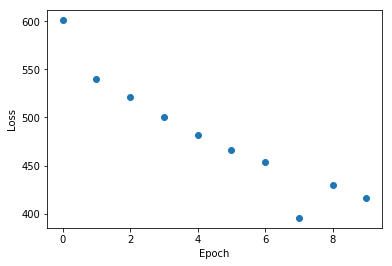

In [7]:
import matplotlib.pyplot as plot

plot.ylabel("Loss")
plot.xlabel("Epoch")
x = range(num_epochs)
y = losses
plot.scatter(x, y)
plot

We see that the losses fall nicely and give us stable learning.

Let's try to evaluate the performance of the model we've trained. For this, we need to define a metric, a measure of model performance. `dc.metrics` holds a collection of metrics already. For this dataset, it is standard to use the ROC-AUC score, the area under the receiver operating characteristic curve (which measures the tradeoff between precision and recall). Luckily, the ROC-AUC score is already available in DeepChem. 

To measure the performance of the model under this metric, we can use the convenience function `model.evaluate()`.

In [9]:
import numpy as np
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
print("Training ROC-AUC Score: %f" % train_scores["mean-roc_auc_score"])
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC-AUC Score: %f" % valid_scores["mean-roc_auc_score"])

Evaluating model
computed_metrics: [0.8771649250815109, 0.9357603765253693, 0.8921563315399849, 0.9004898297731647, 0.7581180668683578, 0.8855151411778919, 0.9301783248128317, 0.8223718544182504, 0.916047175031145, 0.8549905452526758, 0.8922622391520603, 0.8898864462717457]
Training ROC-AUC Score: 0.879578
computed_metrics: [0.8248157126601692, 0.8578042328042328, 0.8487234333045099, 0.83521860701576, 0.6690681818181816, 0.740736370073165, 0.7159916926272066, 0.8246083750205501, 0.81803626089004, 0.7259079467817332, 0.8694579510886489, 0.8070628768303187]
Validation ROC-AUC Score: 0.794786


What's going on under the hood? Could we build `GraphConvModel` ourselves? Of course! The first step is to create a `TensorGraph` object. This object will hold the "computational graph" that defines the computation that a graph convolutional network will perform.

In [10]:
from deepchem.models.tensorgraph.tensor_graph import TensorGraph

tg = TensorGraph(use_queue=False)

Let's now define the inputs to our model. Conceptually, graph convolutions just requires a the structure of the molecule in question and a vector of features for every atom that describes the local chemical environment. However in practice, due to TensorFlow's limitations as a general programming environment, we have to have some auxiliary information as well preprocessed.

`atom_features` holds a feature vector of length 75 for each atom. The other feature inputs are required to support minibatching in TensorFlow. `degree_slice` is an indexing convenience that makes it easy to locate atoms from all molecules with a given degree. `membership` determines the membership of atoms in molecules (atom `i` belongs to molecule `membership[i]`). `deg_adjs` is a list that contains adjacency lists grouped by atom degree For more details, check out the [code](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/mol_graphs.py).

To define feature inputs in `TensorGraph`, we use the `Feature` layer. Conceptually, a `TensorGraph` is a mathematical graph composed of layer objects. `Features` layers have to be the root nodes of the graph since they consitute inputs.

In [12]:
import tensorflow as tf
from deepchem.models.tensorgraph.layers import Feature

atom_features = Feature(shape=(None, 75))
degree_slice = Feature(shape=(None, 2), dtype=tf.int32)
membership = Feature(shape=(None,), dtype=tf.int32)

deg_adjs = []
for i in range(0, 10 + 1):
    deg_adj = Feature(shape=(None, i + 1), dtype=tf.int32)
    deg_adjs.append(deg_adj)

Let's now implement the body of the graph convolutional network. `TensorGraph` has a number of layers that encode various graph operations. Namely, the `GraphConv`, `GraphPool` and `GraphGather` layers. We will also apply standard neural network layers such as `Dense` and `BatchNorm`.

The layers we're adding effect a "feature transformation" that will create one vector for each molecule.

In [13]:
from deepchem.models.tensorgraph.layers import Dense, GraphConv, BatchNorm
from deepchem.models.tensorgraph.layers import GraphPool, GraphGather

batch_size = 50

gc1 = GraphConv(
    64,
    activation_fn=tf.nn.relu,
    in_layers=[atom_features, degree_slice, membership] + deg_adjs)
batch_norm1 = BatchNorm(in_layers=[gc1])
gp1 = GraphPool(in_layers=[batch_norm1, degree_slice, membership] + deg_adjs)
gc2 = GraphConv(
    64,
    activation_fn=tf.nn.relu,
    in_layers=[gp1, degree_slice, membership] + deg_adjs)
batch_norm2 = BatchNorm(in_layers=[gc2])
gp2 = GraphPool(in_layers=[batch_norm2, degree_slice, membership] + deg_adjs)
dense = Dense(out_channels=128, activation_fn=tf.nn.relu, in_layers=[gp2])
batch_norm3 = BatchNorm(in_layers=[dense])
readout = GraphGather(
    batch_size=batch_size,
    activation_fn=tf.nn.tanh,
    in_layers=[batch_norm3, degree_slice, membership] + deg_adjs)    

Let's now make predictions from the `TensorGraph` model. Tox21 is a multitask dataset. That is, there are 12 different datasets grouped together, which share many common molecules, but with different outputs for each. As a result, we have to add a separate output layer for each task. We will use a `for` loop over the `tox21_tasks` list to make this happen. We need to add labels for each

We also have to define a loss for the model which tells the network the objective to minimize during training.

We have to tell `TensorGraph` which layers are outputs with `TensorGraph.add_output(layer)`. Similarly, we tell the network its loss with `TensorGraph.set_loss(loss)`.

In [14]:
from deepchem.models.tensorgraph.layers import Dense, SoftMax, \
    SoftMaxCrossEntropy, WeightedError, Stack
from deepchem.models.tensorgraph.layers import Label, Weights

costs = []
labels = []
for task in range(len(tox21_tasks)):
    classification = Dense(
        out_channels=2, activation_fn=None, in_layers=[readout])

    softmax = SoftMax(in_layers=[classification])
    tg.add_output(softmax)

    label = Label(shape=(None, 2))
    labels.append(label)
    cost = SoftMaxCrossEntropy(in_layers=[label, classification])
    costs.append(cost)
all_cost = Stack(in_layers=costs, axis=1)
weights = Weights(shape=(None, len(tox21_tasks)))
loss = WeightedError(in_layers=[all_cost, weights])
tg.set_loss(loss)

Now that we've successfully defined our graph convolutional model in `TensorGraph`, we need to train it. We can call `fit()`, but we need to make sure that each minibatch of data populates all four `Feature` objects that we've created. For this, we need to create a Python generator that given a batch of data generates a dictionary whose keys are the `Feature` layers and whose values are Numpy arrays we'd like to use for this step of training.

In [15]:
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol

def data_generator(dataset, epochs=1, predict=False, pad_batches=True):
  for epoch in range(epochs):
    if not predict:
        print('Starting epoch %i' % epoch)
    for ind, (X_b, y_b, w_b, ids_b) in enumerate(
        dataset.iterbatches(
            batch_size, pad_batches=pad_batches, deterministic=True)):
      d = {}
      for index, label in enumerate(labels):
        d[label] = to_one_hot(y_b[:, index])
      d[weights] = w_b
      multiConvMol = ConvMol.agglomerate_mols(X_b)
      d[atom_features] = multiConvMol.get_atom_features()
      d[degree_slice] = multiConvMol.deg_slice
      d[membership] = multiConvMol.membership
      for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        d[deg_adjs[i - 1]] = multiConvMol.get_deg_adjacency_lists()[i]
      yield d

Now, we can train the model using `TensorGraph.fit_generator(generator)` which will use the generator we've defined to train the model.

In [16]:
# Epochs set to 1 to render tutorials online.
# Set epochs=10 for better results.
num_epochs = 10
losses = []
for i in range(num_epochs):
  loss = tg.fit_generator(data_generator(train_dataset, epochs=1))
  print("Epoch %d loss: %f" % (i, loss))
  losses.append(loss)

/home/bharath/anaconda3/envs/deepchem/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Starting epoch 0
Epoch 0 loss: 594.527809
Starting epoch 0
Epoch 1 loss: 531.234092
Starting epoch 0
Epoch 2 loss: 517.762582
Starting epoch 0
Epoch 3 loss: 497.836794
Starting epoch 0
Epoch 4 loss: 487.955090
Starting epoch 0
Epoch 5 loss: 467.927695
Starting epoch 0
Epoch 6 loss: 454.166574
Starting epoch 0
Epoch 7 loss: 440.386095
Starting epoch 0
Epoch 8 loss: 429.347466
Starting epoch 0
Epoch 9 loss: 417.903737


Let's now plot these losses and take a quick look.

<module 'matplotlib.pyplot' from '/home/bharath/anaconda3/envs/deepchem/lib/python3.5/site-packages/matplotlib/pyplot.py'>

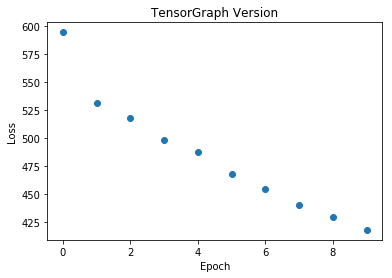

In [17]:
plot.title("TensorGraph Version")
plot.ylabel("Loss")
plot.xlabel("Epoch")
x = range(num_epochs)
y = losses
plot.scatter(x, y)
plot

Now that we have trained our graph convolutional method, let's evaluate its performance. We again have to use our defined generator to evaluate model performance.

In [18]:
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, np.mean, mode="classification")

def reshape_y_pred(y_true, y_pred):
    """
    TensorGraph.Predict returns a list of arrays, one for each output
    We also have to remove the padding on the last batch
    Metrics taks results of shape (samples, n_task, prob_of_class)
    """
    n_samples = len(y_true)
    retval = np.stack(y_pred, axis=1)
    return retval[:n_samples]
    

print("Evaluating model")
train_predictions = tg.predict_on_generator(data_generator(train_dataset, predict=True))
train_predictions = reshape_y_pred(train_dataset.y, train_predictions)
train_scores = metric.compute_metric(train_dataset.y, train_predictions, train_dataset.w)
print("Training ROC-AUC Score: %f" % train_scores)

valid_predictions = tg.predict_on_generator(data_generator(valid_dataset, predict=True))
valid_predictions = reshape_y_pred(valid_dataset.y, valid_predictions)
valid_scores = metric.compute_metric(valid_dataset.y, valid_predictions, valid_dataset.w)
print("Valid ROC-AUC Score: %f" % valid_scores)

Evaluating model
computed_metrics: [0.8810831188046453, 0.9410911408156711, 0.8854550019690002, 0.9028137977956704, 0.773331153887356, 0.9026144383088501, 0.921387266897649, 0.8147533328312118, 0.9073881391674727, 0.8475690023073053, 0.888040047559479, 0.8659284275885215]
Training ROC-AUC Score: 0.877621
computed_metrics: [0.8066096076782269, 0.796709656084656, 0.8259227233422837, 0.8337569903406202, 0.6471363636363636, 0.7295649437495083, 0.6864832121841467, 0.8069236008360929, 0.813327054391335, 0.7387405609492987, 0.8640206951064695, 0.8111111111111111]
Valid ROC-AUC Score: 0.780026


Success! The model we've constructed behaves nearly identically to `GraphConvModel`. If you're looking to build your own custom models, you can follow the example we've provided here to do so. We hope to see exciting constructions from your end soon!

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on GitHub
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!